In this example we use AdOSE method on `cause-effect` pairs.

# Import Packages

In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, clear_output

np.set_printoptions(precision=5 , suppress=True)

In [2]:
# import AdOR package
from adose import *

## Data

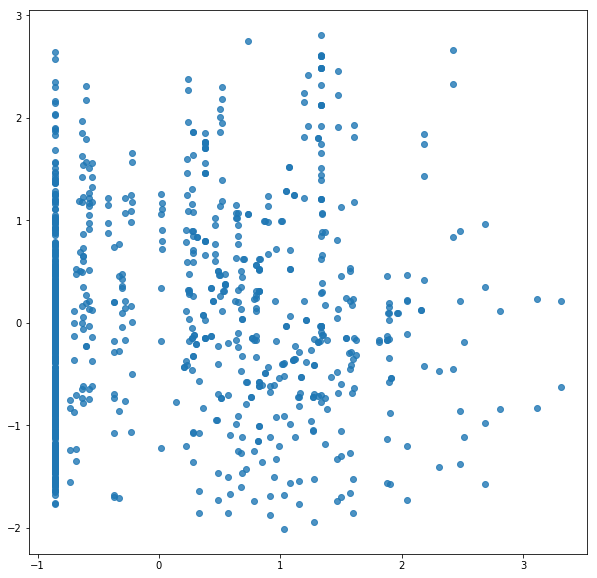

1030


In [5]:
DatasetIdx = '0026'

MetaFile = pd.read_csv('pairs\\pairmeta.txt', delim_whitespace=True, encoding='utf-8', header=None,
                       names=['SetIdx','FirstColCause','LastColCause','FirstColEffect','LastColEffect','Weight'])
DataSetMeta = MetaFile.iloc[np.where(MetaFile.SetIdx == np.int32(DatasetIdx))[0][0]]
DataFile = pd.read_csv('pairs\\pair'+DatasetIdx+'.txt', delim_whitespace=True, encoding='utf-8', header=None, dtype=np.float32)

RawX = np.asarray(DataFile.iloc[:,int(DataSetMeta.FirstColCause-1):int(DataSetMeta.LastColCause)])
RawY = np.asarray(DataFile.iloc[:,int(DataSetMeta.FirstColEffect-1):int(DataSetMeta.LastColEffect)])
X = (RawX-np.mean(RawX))/np.std(RawX)
Y = (RawY-np.mean(RawY))/np.std(RawY)

NumSamples = X.shape[0]
dimX = X.shape[1]
dimY = Y.shape[1]

Hx = np.arange(np.min(X),np.max(X),0.01)[np.newaxis].T

plt.figure(figsize=(10,10))
plt.scatter(X, Y, alpha=0.8)
#plt.scatter(Y, X, c='r',alpha=0.5)
plt.show()
print(NumSamples)

In [6]:
BatchSize=1024

In [9]:
STT = 600
print('Y entropy: ',np.mean([kNNEntropy(Y, KOfNN=i) for i in range(STT, STT+5)]))
print('X entropy: ',np.mean([kNNEntropy(X, KOfNN=i) for i in range(STT, STT+5)]))

Y entropy:  1.359869820759271
X entropy:  1.489213534903627


# Forward Direction

# Create New Model

In [10]:
# struct new model using adose class
MODEL1 = adose(NumOfRegressors=dimX, BatchSize=BatchSize)

In [11]:
# add dense layers (fully_connected) to random generator network.
MODEL1.RanGen_GetDenseLayer(LayerID='hidden1', LayerSize=10, Activation=tf.nn.leaky_relu,
                            WeightInitializer=tf.contrib.layers.xavier_initializer(),
                            BiasInitializer=tf.initializers.random_uniform(minval=-1, maxval=+1))
MODEL1.RanGen_GetDenseLayer(LayerID='out', LayerSize=1, Activation=None,
                            WeightInitializer=tf.contrib.layers.xavier_initializer(),
                            BiasInitializer=tf.initializers.random_uniform(minval=-1, maxval=+1))

In [12]:
# add dense layers (fully_connected) to regression network.
MODEL1.Reg_GetDenseLayer(LayerID='hidden1', LayerSize=6, Activation=tf.nn.tanh,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL1.Reg_GetDenseLayer(LayerID='hidden2', LayerSize=6, Activation=tf.nn.sigmoid,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL1.Reg_GetDenseLayer(LayerID='hidden3', LayerSize=6, Activation=tf.nn.leaky_relu,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL1.Reg_GetDenseLayer(LayerID='out', LayerSize=1, Activation=None,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())

In [13]:
# add dense layers (fully_connected) to KL-divergence network.
MODEL1.KL_GetDenseLayer(LayerID='hidden1', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL1.KL_GetDenseLayer(LayerID='hidden2', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL1.KL_GetDenseLayer(LayerID='hidden3', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
# specify 'out' for last layer. it forces model not to add bias term to this layer
MODEL1.KL_GetDenseLayer(LayerID='out', LayerSize=1, Activation=None,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())

In [14]:
# when the structure of network is constructed, call 'ConstructGraph' method. it creates the whole computational graph
MODEL1.ConstructGraph()

In [15]:
# specify optimizer for each net
MODEL1.Reg_DefineOptimizer(optimizer=tf.train.AdamOptimizer, beta1=0.9, beta2=0.999)
MODEL1.KL_DefineOptimizer(optimizer=tf.train.AdamOptimizer, beta1=0.9, beta2=0.999)

In [16]:
# you can create tensorboard summary. list of scalers and histograms can be changed by 'Options' input
MODEL1.TensorboardSummaryCreator(directory="summaries\\CE_AdOSE_"+DatasetIdx+"_01", 
                                 Options=['loss_reg', 'loss_kl', 'tr_phs', 'all_reg_weights', 'all_rangen_weights', 'all_kl_weights'])

In [168]:
WHERE = np.where(Y>4.5)[0]
X = np.delete(X,WHERE)[np.newaxis].T
Y = np.delete(Y,WHERE)[np.newaxis].T

In [127]:
NumSamples -= len(WHERE)

# Train the Model

In [17]:
# hyper-parameters

# learn rates
RLearnRate = 0.0005
KLLearnRate = 0.0005

# number of updating steps at each iteration
nReg_Steps = 10
nKL_Steps = 10

# number of whole iterations
MaxIters = 1500

In [18]:
# starting a new tensorflow session

# configurations
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # making sure Tensorflow doesn't overflow the GPU

# call 'GetSession' method to create a new session
MODEL1.GetSession(config=config)

iteration: 0     Estimated Entropy of Residual:  1.3044103781468444


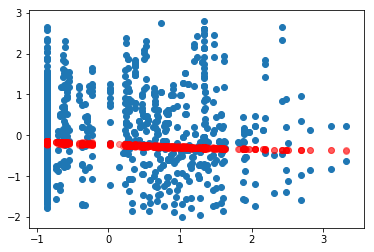

iteration: 50     Estimated Entropy of Residual:  1.770629072046796


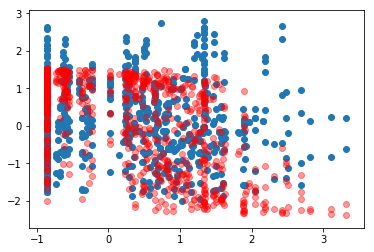

iteration: 100     Estimated Entropy of Residual:  1.7779986612141383


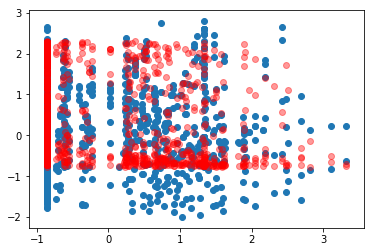

iteration: 150     Estimated Entropy of Residual:  1.6682417142569173


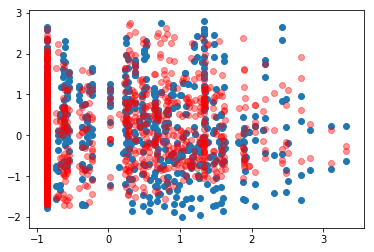

iteration: 200     Estimated Entropy of Residual:  1.695556106506531


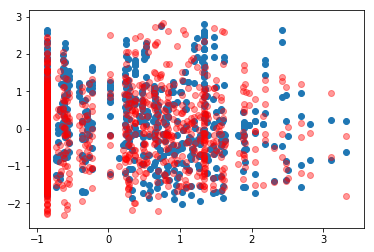

iteration: 250     Estimated Entropy of Residual:  1.701015565433801


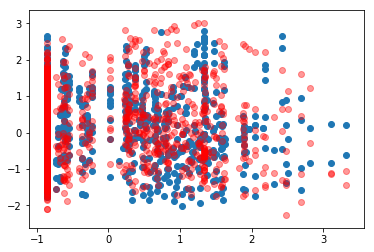

iteration: 300     Estimated Entropy of Residual:  1.7143826948039407


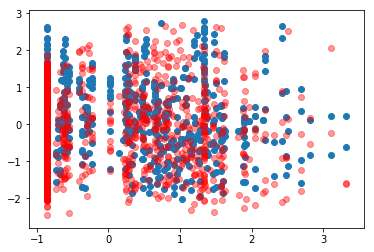

iteration: 350     Estimated Entropy of Residual:  1.6656973512610023


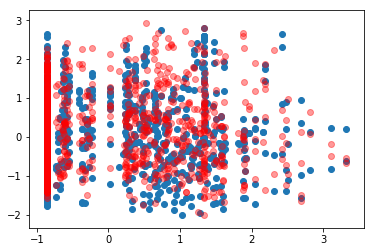

iteration: 400     Estimated Entropy of Residual:  1.6855355893439468


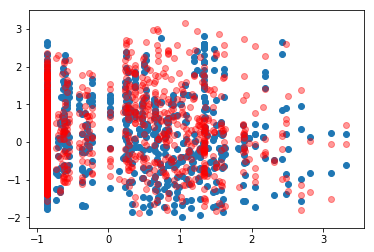

iteration: 450     Estimated Entropy of Residual:  1.680033990844095


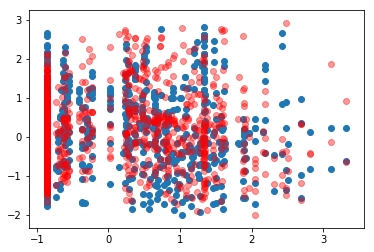

iteration: 500     Estimated Entropy of Residual:  1.7173892761627751


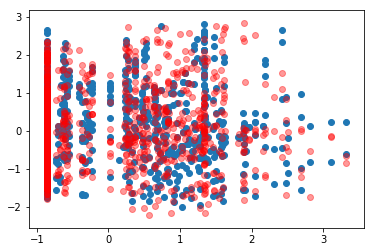

iteration: 550     Estimated Entropy of Residual:  1.6434290330054453


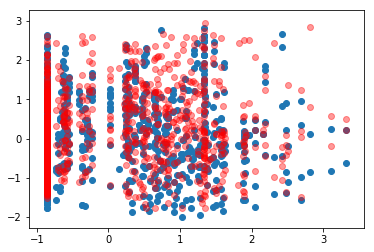

iteration: 600     Estimated Entropy of Residual:  1.6227871358375423


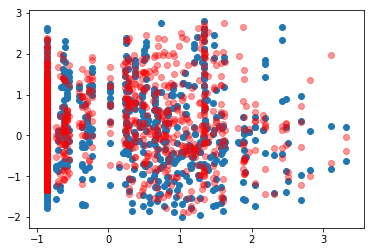

iteration: 650     Estimated Entropy of Residual:  1.618242319023726


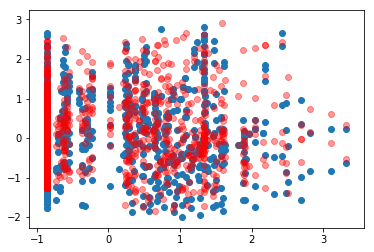

iteration: 700     Estimated Entropy of Residual:  1.704761692315595


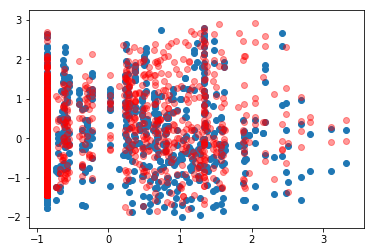

iteration: 750     Estimated Entropy of Residual:  1.713475870362143


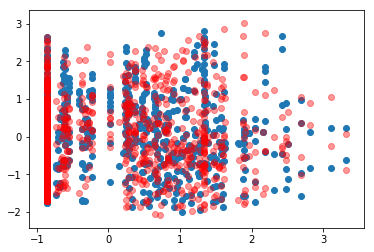

iteration: 800     Estimated Entropy of Residual:  1.640488936878798


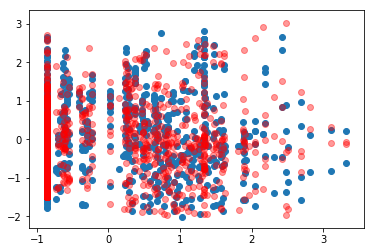

iteration: 850     Estimated Entropy of Residual:  1.7080069130490787


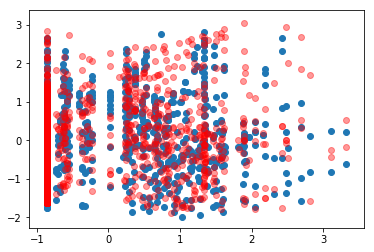

iteration: 900     Estimated Entropy of Residual:  1.7342087150590055


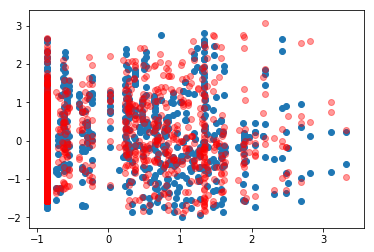

iteration: 950     Estimated Entropy of Residual:  1.6788396311949598


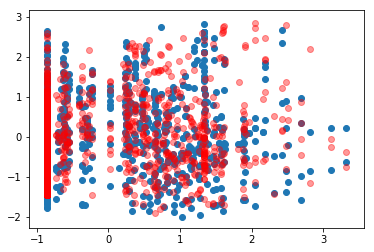

iteration: 1000     Estimated Entropy of Residual:  1.6229115817543889


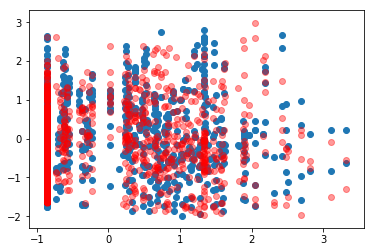

iteration: 1050     Estimated Entropy of Residual:  1.7242960874388085


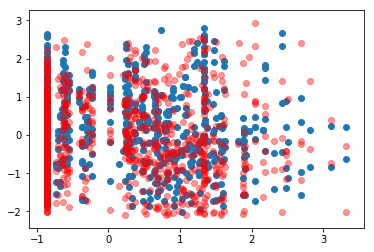

iteration: 1100     Estimated Entropy of Residual:  1.6554557829058671


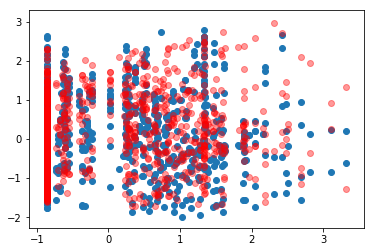

iteration: 1150     Estimated Entropy of Residual:  1.698823640410997


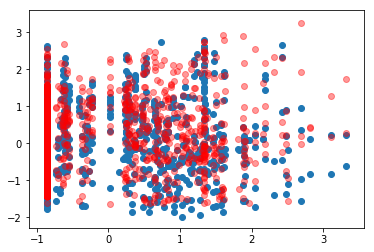

iteration: 1200     Estimated Entropy of Residual:  1.6405311924673596


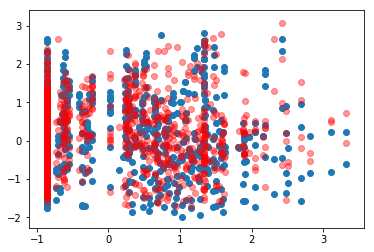

iteration: 1250     Estimated Entropy of Residual:  1.623102993275189


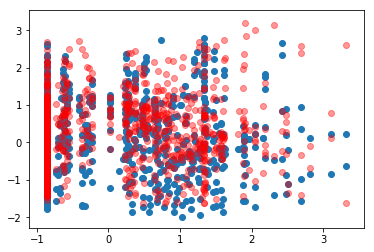

iteration: 1300     Estimated Entropy of Residual:  1.6744352987491435


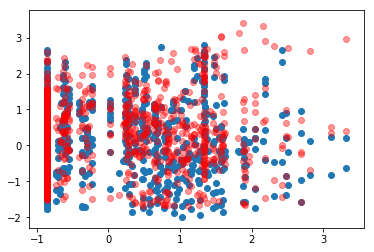

iteration: 1350     Estimated Entropy of Residual:  1.6159583889129512


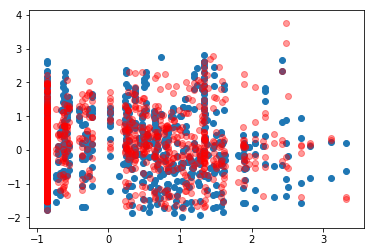

iteration: 1400     Estimated Entropy of Residual:  1.7041135655970452


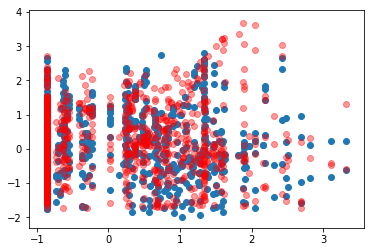

iteration: 1450     Estimated Entropy of Residual:  1.6513520634163688


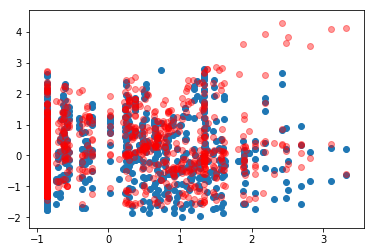

In [19]:
EnsemblePredicts = list()
np_loss_all = list()
Res_Entr_all = list()
Hx = np.arange(np.min(X),np.max(X),0.05)[np.newaxis].T
NumRands = 5000
EstimatedHist = np.zeros(shape=(np.size(Hx), NumRands))
CC = -1

# iteration
for iters in range(MaxIters):
    
    RandomNum = np.random.randn(np.shape(Y)[0],np.shape(Y)[1])
    
    # use 'UpdateRegNet' method to update regression network by back-propagattion
    AllPredicts, _, np_loss, _, _, Res_Entr = MODEL1.UpdateRegNet(X=X, Y=Y, RandomIn=RandomNum,
                                                                 iteration=iters, RegLearnRate=RLearnRate, nReg_Steps=nReg_Steps)
    np_loss_all.append(np_loss)
    Res_Entr_all.append(Res_Entr)
    
    # use 'UpdateKLNet' method to update KL-divergence network by back-propagattion
    _ = MODEL1.UpdateKLNet(X=X, Y=Y, RandomIn=RandomNum,
                           iteration=iters, KLLearnRate=KLLearnRate, nKL_Steps=nKL_Steps)
    
    nKL_Steps = np.min([40, np.max([5, np.int32(30-25*np_loss)])])#np.min([30, np.int32(30/np.exp(0.056*R_loss))])
    nReg_Steps = np.min([40, np.max([5, np.int32(30+25*np_loss)])])#np.min([30, np.int32(30/np.exp(-0.056*R_loss))])
    
    # verbose at each 50 iteration
    if iters%50 == 0:
        print('iteration:', iters , '    Estimated Entropy of Residual: ', Res_Entr)
        
        
        
        Imlists = sorted(zip(*[X, AllPredicts]))
        new_x, new_y = list(zip(*Imlists))
        
        plt.figure()
        plt.scatter(X, Y)
        plt.scatter(new_x, new_y, color='r', alpha=0.4)
        plt.show()
        
    if iters>=1000:
        EnsemblePredicts.append(AllPredicts)
        for j in range(NumRands//500):
            CC += 1
            EstimatedHist[:,CC] = MODEL1.PredictAfterTrain(X=Hx, RandomIn=np.random.randn(Hx.size,1))[:,0]

# ensemble
EnsemblePredictsWhole = np.mean(EnsemblePredicts, axis=0)
Imlists = sorted(zip(*[X, EnsemblePredictsWhole]))
new_x_AT, new_y_AT = list(zip(*Imlists))

In [20]:
# use 'EndSession' method to close session after training.
# Note that by closing session, the trained model no longer can be used.
MODEL1.EndSession()

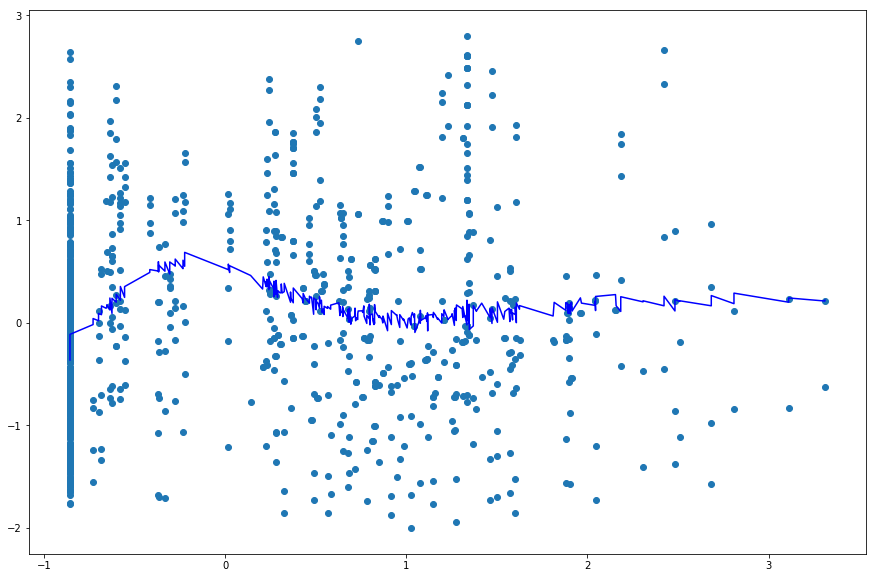

In [21]:
plt.figure(figsize=(15,10))
plt.plot(new_x_AT, new_y_AT, 'b')
plt.scatter(X, Y)
plt.show()

In [22]:
ImlistsMain = sorted(zip(*[X, Y]))
new_x_Main, new_y_Main = list(zip(*ImlistsMain))
new_y_AT = np.asarray(new_y_AT)
InData = np.concatenate([new_x_Main, new_y_Main-new_y_AT], axis=1)
ForwardError = np.asarray(new_y_Main-new_y_AT)
ForwardPredict = np.asarray(new_y_AT)

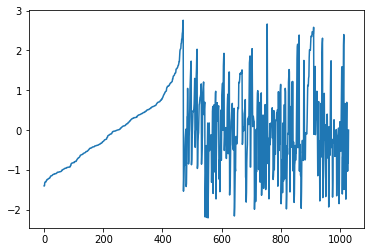

0.9418337460527548


In [23]:
plt.plot(ForwardError)
plt.show()
print(np.std(ForwardError))

In [24]:
def Loss_MI(preds):
    ScaledPreds = tf.add(preds, tf.stop_gradient(tf.negative(tf.reduce_max(preds))))
    JointData = tf.gather(ScaledPreds, tf.range(0, tf.div(tf.size(ScaledPreds),2), 1))
    MarginalData = tf.gather(ScaledPreds, tf.range(tf.div(tf.size(ScaledPreds),2), tf.size(ScaledPreds), 1))
    return tf.reduce_mean(JointData) - tf.log(tf.reduce_mean(tf.exp(MarginalData)))

In [25]:
tf.reset_default_graph()

InputSize = 2
batch_size = 2*BatchSize//2

layer_ids = ['hidden1','out']#['hidden1','hidden2','hidden3','hidden4','hidden5','out']
layer_sizes = [InputSize, 40, 1]#[InputSize, 5, 10, 10, 5, 2, 1]

# Inputs and Labels
train_inputs = tf.placeholder(tf.float32, shape=[batch_size, layer_sizes[0]], name='train_inputs')


# Learning Rate
tf_learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')


# Weight and Bias definitions
for idx, lid in enumerate(layer_ids):
    #print(idx,'   ',lid)
    with tf.variable_scope(lid):
        w = tf.get_variable('weights',shape=[layer_sizes[idx], layer_sizes[idx+1]],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('bias',shape= [layer_sizes[idx+1]],
                            initializer=tf.contrib.layers.xavier_initializer())

# Calculating Predictions
h = train_inputs
for lid in layer_ids:
    with tf.variable_scope(lid,reuse=True):
        w, b = tf.get_variable('weights'), tf.get_variable('bias')
        #print(w,'\n\n')
        if lid != 'out':
            h = tf.nn.leaky_relu(tf.matmul(h,w)+b,name=lid+'_output')
        else:
            h = tf.nn.xw_plus_b(h,w,b,name=lid+'_output')


# Calculating Loss
tf_loss = tf.negative(Loss_MI(h), name='loss_MINE')

# Optimizer
optimizer = tf.train.AdamOptimizer(tf_learning_rate, beta1=0.96)
grads_and_vars = optimizer.compute_gradients(tf_loss)
tf_loss_minimize = optimizer.minimize(tf_loss)

In [26]:
n_epochs = 5000
LearningRate = 0.00005

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # making sure Tensorflow doesn't overflow the GPU

session = tf.InteractiveSession(config=config)

tf.global_variables_initializer().run()

avg_loss = list()
for epoch in range(n_epochs):
    loss_per_epoch = []
    
    JointBatchIndeces = batch_index_generator(NumSamples, batch_size//2, 2*NumSamples//batch_size)
    MarginalBatchIndeces = batch_index_generator(NumSamples, batch_size//2, 2*NumSamples//batch_size)
    for i in range(2*NumSamples//batch_size):
        
        # =================================== Training for one step ========================================
        batch_joint = InData[JointBatchIndeces[:,i],:]    # Get one batch of joint data
        batch_marginal = InData[MarginalBatchIndeces[:,i],:]    # Get one batch of marginal data
        batch_marginal[:,0:dimX] = batch_joint[:,0:dimX]
        AllBatch = np.concatenate([batch_joint, batch_marginal], axis=0)
        l,_ = session.run([tf_loss, tf_loss_minimize],
                          feed_dict={train_inputs: AllBatch,
                                     tf_learning_rate: LearningRate})
        
        loss_per_epoch.append(l)
    if epoch%50==0:
        print('Average loss in epoch %d: %.5f'%(epoch,-np.mean(loss_per_epoch)))    
    avg_loss.append(-np.mean(loss_per_epoch))
    
    

session.close()

Average loss in epoch 0: -0.01716
Average loss in epoch 50: -0.00976
Average loss in epoch 100: -0.00486
Average loss in epoch 150: -0.00130
Average loss in epoch 200: 0.00028
Average loss in epoch 250: 0.00008
Average loss in epoch 300: 0.00092
Average loss in epoch 350: 0.00122
Average loss in epoch 400: 0.00131
Average loss in epoch 450: 0.00217
Average loss in epoch 500: 0.00312
Average loss in epoch 550: 0.00332
Average loss in epoch 600: 0.00338
Average loss in epoch 650: 0.00349
Average loss in epoch 700: 0.00438
Average loss in epoch 750: 0.00671
Average loss in epoch 800: 0.00538
Average loss in epoch 850: 0.00500
Average loss in epoch 900: 0.00356
Average loss in epoch 950: 0.00652
Average loss in epoch 1000: 0.00728
Average loss in epoch 1050: 0.00512
Average loss in epoch 1100: 0.00764
Average loss in epoch 1150: 0.00886
Average loss in epoch 1200: 0.00781
Average loss in epoch 1250: 0.00725
Average loss in epoch 1300: 0.00839
Average loss in epoch 1350: 0.00586
Average los

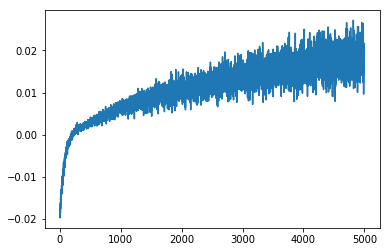

0.018059568


In [27]:
plt.plot(avg_loss)
plt.show()
print(np.mean(avg_loss[-500:-1]))

# Backward Direction

# Create New Model

In [28]:
# struct new model using adose class
MODEL2 = adose(NumOfRegressors=dimY, BatchSize=BatchSize)

In [29]:
# add dense layers (fully_connected) to random generator network.
MODEL2.RanGen_GetDenseLayer(LayerID='hidden1', LayerSize=10, Activation=tf.nn.leaky_relu,
                            WeightInitializer=tf.contrib.layers.xavier_initializer(),
                            BiasInitializer=tf.initializers.random_uniform(minval=-1, maxval=+1))
MODEL2.RanGen_GetDenseLayer(LayerID='out', LayerSize=1, Activation=None,
                            WeightInitializer=tf.contrib.layers.xavier_initializer(),
                            BiasInitializer=tf.initializers.random_uniform(minval=-1, maxval=+1))

In [30]:
# add dense layers (fully_connected) to regression network.
MODEL2.Reg_GetDenseLayer(LayerID='hidden1', LayerSize=6, Activation=tf.nn.tanh,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL2.Reg_GetDenseLayer(LayerID='hidden2', LayerSize=6, Activation=tf.nn.sigmoid,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL2.Reg_GetDenseLayer(LayerID='hidden3', LayerSize=6, Activation=tf.nn.leaky_relu,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL2.Reg_GetDenseLayer(LayerID='out', LayerSize=1, Activation=None,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())

In [31]:
# add dense layers (fully_connected) to KL-divergence network.
MODEL2.KL_GetDenseLayer(LayerID='hidden1', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL2.KL_GetDenseLayer(LayerID='hidden2', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL2.KL_GetDenseLayer(LayerID='hidden3', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
# specify 'out' for last layer. it forces model not to add bias term to this layer
MODEL2.KL_GetDenseLayer(LayerID='out', LayerSize=1, Activation=None,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())

In [32]:
# when the structure of network is constructed, call 'ConstructGraph' method. it creates the whole computational graph
MODEL2.ConstructGraph()

In [33]:
# specify optimizer for each net
MODEL2.Reg_DefineOptimizer(optimizer=tf.train.AdamOptimizer, beta1=0.9, beta2=0.999)
MODEL2.KL_DefineOptimizer(optimizer=tf.train.AdamOptimizer, beta1=0.9, beta2=0.999)

In [34]:
# you can create tensorboard summary. list of scalers and histograms can be changed by 'Options' input
MODEL2.TensorboardSummaryCreator(directory="summaries\\CE_AdOSE_"+DatasetIdx+"_Back_01",
                                 Options=['loss_reg', 'loss_kl', 'tr_phs', 'all_reg_weights', 'all_rangen_weights', 'all_kl_weights'])

# Train the Model

In [35]:
# hyper-parameters

# learn rates
RLearnRate = 0.0005
KLLearnRate = 0.0005

# number of updating steps at each iteration
nReg_Steps = 10
nKL_Steps = 10

# number of whole iterations
MaxIters = 1500

In [36]:
# starting a new tensorflow session

# configurations
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # making sure Tensorflow doesn't overflow the GPU

# call 'GetSession' method to create a new session
MODEL2.GetSession(config=config)

iteration: 0     Estimated Entropy of Residual:  0.8242857263669907


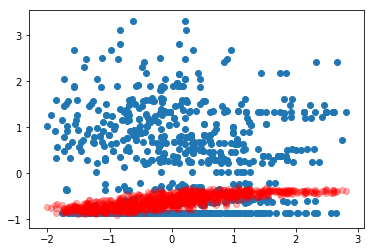

iteration: 50     Estimated Entropy of Residual:  1.3666073490884645


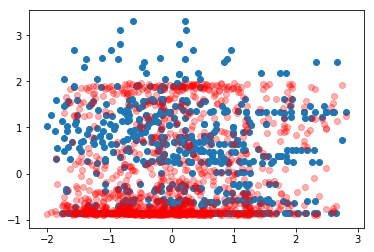

iteration: 100     Estimated Entropy of Residual:  1.1941486597848963


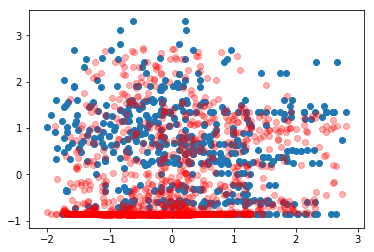

iteration: 150     Estimated Entropy of Residual:  0.9008324295151491


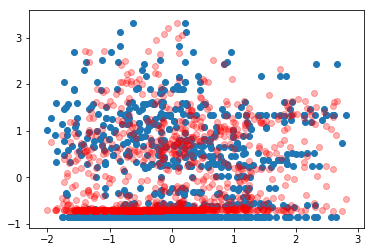

iteration: 200     Estimated Entropy of Residual:  1.0509600771273941


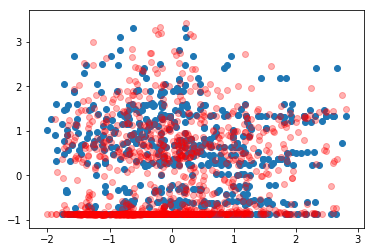

iteration: 250     Estimated Entropy of Residual:  0.6877893232649241


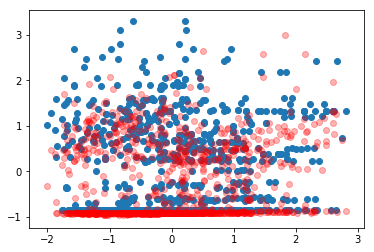

iteration: 300     Estimated Entropy of Residual:  0.7510683384117742


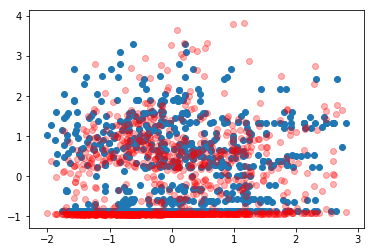

iteration: 350     Estimated Entropy of Residual:  0.9601041917069408


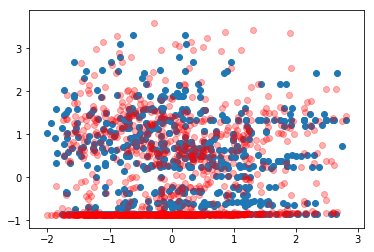

iteration: 400     Estimated Entropy of Residual:  0.8562043159976054


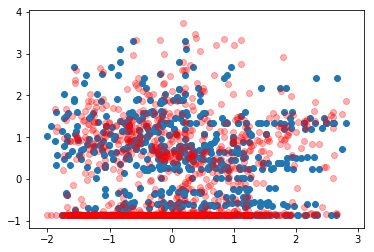

iteration: 450     Estimated Entropy of Residual:  0.8648461583908267


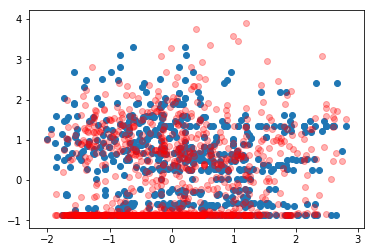

iteration: 500     Estimated Entropy of Residual:  0.8346123568256907


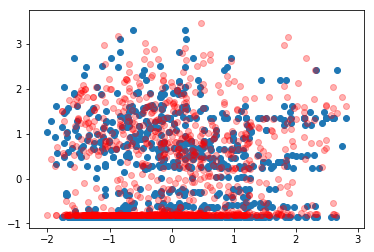

iteration: 550     Estimated Entropy of Residual:  0.6970679486435283


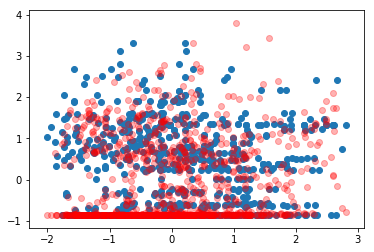

iteration: 600     Estimated Entropy of Residual:  0.6961398299435464


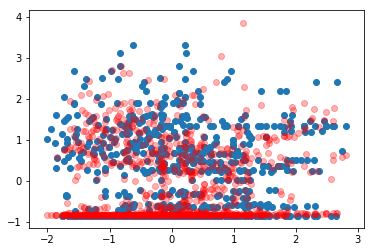

iteration: 650     Estimated Entropy of Residual:  0.774940800288757


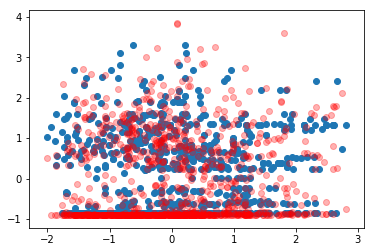

iteration: 700     Estimated Entropy of Residual:  0.620427326654875


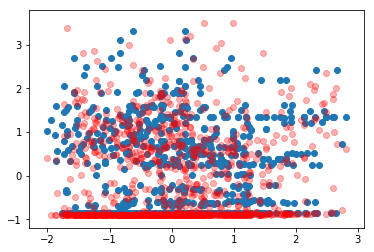

iteration: 750     Estimated Entropy of Residual:  0.6927961862809111


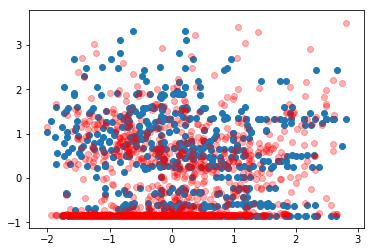

iteration: 800     Estimated Entropy of Residual:  0.6732835428136625


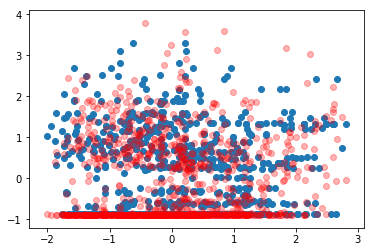

iteration: 850     Estimated Entropy of Residual:  0.5243279363041413


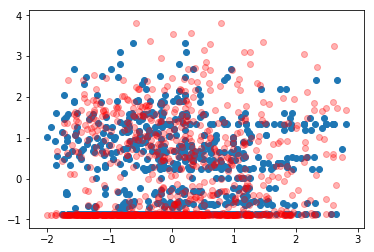

iteration: 900     Estimated Entropy of Residual:  0.5936724858152758


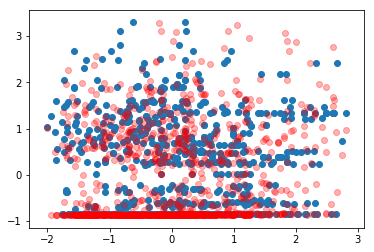

iteration: 950     Estimated Entropy of Residual:  0.6681239400849273


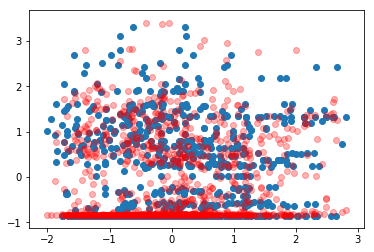

iteration: 1000     Estimated Entropy of Residual:  0.6380293338005414


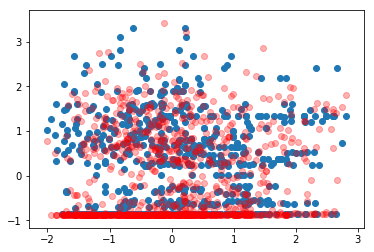

iteration: 1050     Estimated Entropy of Residual:  0.5952939220376408


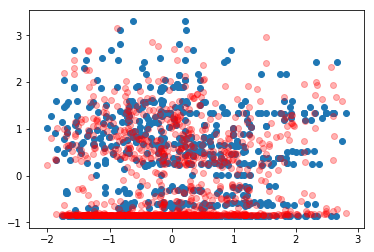

iteration: 1100     Estimated Entropy of Residual:  0.6138246539960894


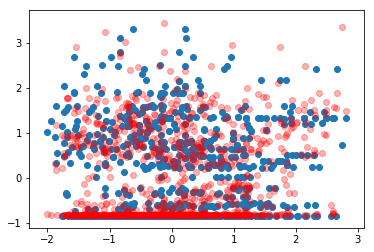

iteration: 1150     Estimated Entropy of Residual:  0.6569417934136501


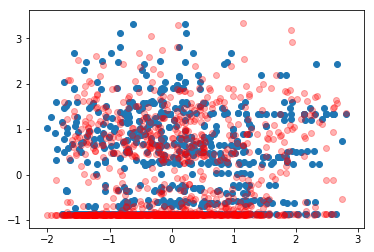

iteration: 1200     Estimated Entropy of Residual:  0.6757234995028112


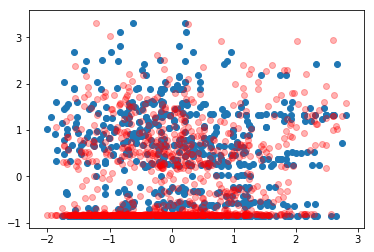

iteration: 1250     Estimated Entropy of Residual:  0.7312666249825672


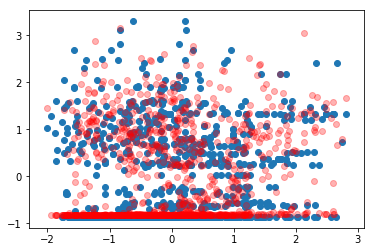

iteration: 1300     Estimated Entropy of Residual:  0.5967775333299761


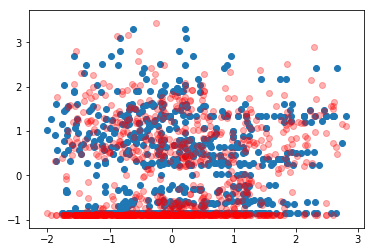

iteration: 1350     Estimated Entropy of Residual:  0.7170647112981285


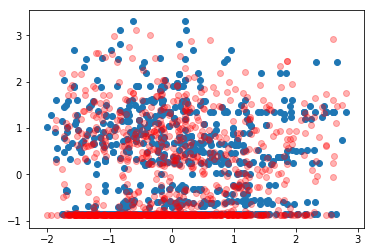

iteration: 1400     Estimated Entropy of Residual:  0.6035292931319791


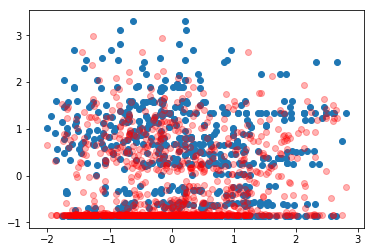

iteration: 1450     Estimated Entropy of Residual:  0.6704413911369058


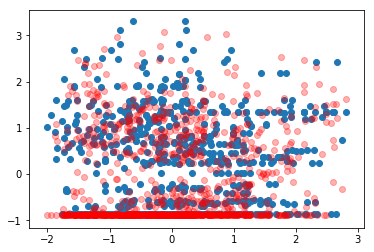

In [37]:
EnsemblePredictsRev = list()
np_loss_allRev = list()
Res_Entr_allRev = list()
HxRev = np.arange(np.min(Y),np.max(Y),0.05)[np.newaxis].T
NumRands = 5000
EstimatedHistRev = np.zeros(shape=(np.size(HxRev), NumRands))
CC = -1

# iteration
for iters in range(MaxIters):
    
    RandomNum = np.random.randn(np.shape(X)[0],np.shape(X)[1])
    
    # use 'UpdateRegNet' method to update regression network by back-propagattion
    AllPredicts, _, np_lossRev, _, _, Res_Entr = MODEL2.UpdateRegNet(X=Y, Y=X, RandomIn=RandomNum,
                                                                 iteration=iters, RegLearnRate=RLearnRate, nReg_Steps=nReg_Steps)
    np_loss_allRev.append(np_lossRev)
    Res_Entr_allRev.append(Res_Entr)
    
    # use 'UpdateKLNet' method to update KL-divergence network by back-propagattion
    _ = MODEL2.UpdateKLNet(X=Y, Y=X, RandomIn=RandomNum,
                           iteration=iters, KLLearnRate=KLLearnRate, nKL_Steps=nKL_Steps)
    
    nKL_Steps = np.min([40, np.max([5, np.int32(30-25*np_lossRev)])])#np.min([30, np.int32(30/np.exp(0.056*R_loss))])
    nReg_Steps = np.min([40, np.max([5, np.int32(30+25*np_lossRev)])])#np.min([30, np.int32(30/np.exp(-0.056*R_loss))])
    
    
    # verbose at each 50 iteration
    if iters%50 == 0:
        print('iteration:', iters , '    Estimated Entropy of Residual: ', Res_Entr)
        
        Imlists = sorted(zip(*[Y, AllPredicts]))
        new_x, new_y = list(zip(*Imlists))
        
        plt.figure()
        plt.scatter(Y, X)
        plt.scatter(new_x, new_y, color='r', alpha=0.3)
        plt.show()
        
    if iters>=1000:
        EnsemblePredictsRev.append(AllPredicts)
        for j in range(NumRands//500):
            CC += 1
            EstimatedHistRev[:,CC] = MODEL2.PredictAfterTrain(X=HxRev, RandomIn=np.random.randn(HxRev.size,1))[:,0]

# ensemble
EnsemblePredictsWholeRev = np.mean(EnsemblePredictsRev, axis=0)
Imlists = sorted(zip(*[Y, EnsemblePredictsWholeRev]))
new_x_ATRev, new_y_ATRev = list(zip(*Imlists))

In [38]:
# use 'EndSession' method to close session after training.
# Note that by closing session, the trained model no longer can be used.
MODEL2.EndSession()

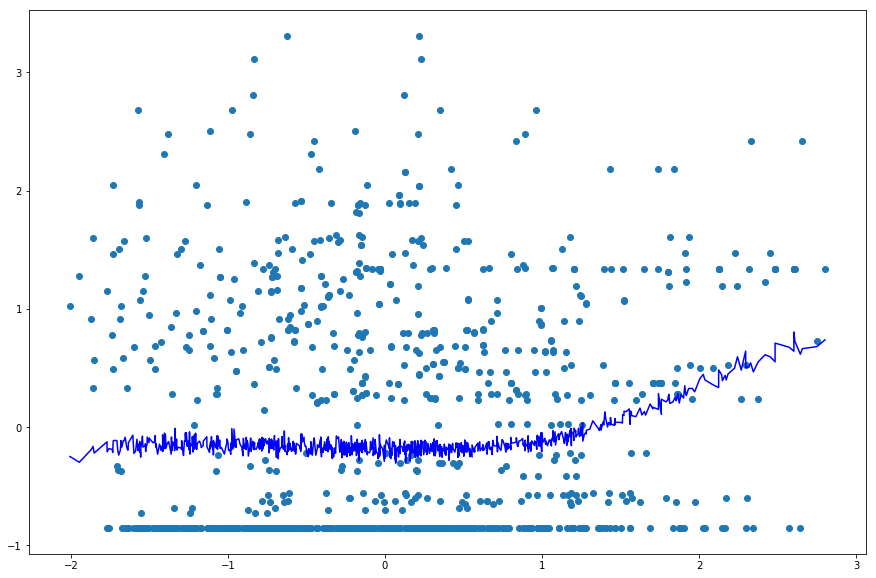

In [40]:
plt.figure(figsize=(15,10))
plt.plot(new_x_ATRev, new_y_ATRev, 'b')
plt.scatter(Y, X)
plt.show()

In [41]:
ImlistsMain = sorted(zip(*[Y, X]))
new_x_Main, new_y_Main = list(zip(*ImlistsMain))
new_y_ATRev = np.asarray(new_y_ATRev)
InData = np.concatenate([new_x_Main, new_y_Main-new_y_ATRev], axis=1)
BackwardError = np.asarray(new_y_Main-new_y_ATRev)
BackwardPredict = np.asarray(new_y_ATRev)

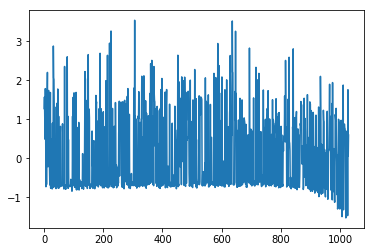

0.984392135557935


In [42]:
plt.plot(BackwardError)
plt.show()
print(np.std(BackwardError))

In [43]:
tf.reset_default_graph()

InputSize = 2
batch_size = 2*BatchSize//2

layer_ids = ['hidden1','out']#['hidden1','hidden2','hidden3','hidden4','hidden5','out']
layer_sizes = [InputSize, 40, 1]#[InputSize, 5, 10, 10, 5, 2, 1]

# Inputs and Labels
train_inputs = tf.placeholder(tf.float32, shape=[batch_size, layer_sizes[0]], name='train_inputs')


# Learning Rate
tf_learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')


# Weight and Bias definitions
for idx, lid in enumerate(layer_ids):
    #print(idx,'   ',lid)
    with tf.variable_scope(lid):
        w = tf.get_variable('weights',shape=[layer_sizes[idx], layer_sizes[idx+1]],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('bias',shape= [layer_sizes[idx+1]],
                            initializer=tf.contrib.layers.xavier_initializer())

# Calculating Predictions
h = train_inputs
for lid in layer_ids:
    with tf.variable_scope(lid,reuse=True):
        w, b = tf.get_variable('weights'), tf.get_variable('bias')
        #print(w,'\n\n')
        if lid != 'out':
            h = tf.nn.leaky_relu(tf.matmul(h,w)+b,name=lid+'_output')
        else:
            h = tf.nn.xw_plus_b(h,w,b,name=lid+'_output')


# Calculating Loss
tf_loss = tf.negative(Loss_MI(h), name='loss_MINE')

# Optimizer
optimizer = tf.train.AdamOptimizer(tf_learning_rate, beta1=0.96)
grads_and_vars = optimizer.compute_gradients(tf_loss)
tf_loss_minimize = optimizer.minimize(tf_loss)

In [44]:
n_epochs = 5000
LearningRate = 0.00005

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # making sure Tensorflow doesn't overflow the GPU

session = tf.InteractiveSession(config=config)

tf.global_variables_initializer().run()

avg_lossRev = list()
for epoch in range(n_epochs):
    loss_per_epoch = []
    
    JointBatchIndeces = batch_index_generator(NumSamples, batch_size//2, 2*NumSamples//batch_size)
    MarginalBatchIndeces = batch_index_generator(NumSamples, batch_size//2, 2*NumSamples//batch_size)
    for i in range(2*NumSamples//batch_size):
        
        # =================================== Training for one step ========================================
        batch_joint = InData[JointBatchIndeces[:,i],:]    # Get one batch of joint data
        batch_marginal = InData[MarginalBatchIndeces[:,i],:]    # Get one batch of marginal data
        batch_marginal[:,0:dimX] = batch_joint[:,0:dimX]
        AllBatch = np.concatenate([batch_joint, batch_marginal], axis=0)
        l,_ = session.run([tf_loss, tf_loss_minimize],
                          feed_dict={train_inputs: AllBatch,
                                     tf_learning_rate: LearningRate})
        
        loss_per_epoch.append(l)
    if epoch%50==0:
        print('Average loss in epoch %d: %.5f'%(epoch,-np.mean(loss_per_epoch)))    
    avg_lossRev.append(-np.mean(loss_per_epoch))
    
    

session.close()

Average loss in epoch 0: -0.07242
Average loss in epoch 50: -0.04796
Average loss in epoch 100: -0.03174
Average loss in epoch 150: -0.02061
Average loss in epoch 200: -0.01378
Average loss in epoch 250: -0.00879
Average loss in epoch 300: -0.00755
Average loss in epoch 350: -0.00414
Average loss in epoch 400: -0.00161
Average loss in epoch 450: -0.00101
Average loss in epoch 500: 0.00086
Average loss in epoch 550: -0.00064
Average loss in epoch 600: 0.00335
Average loss in epoch 650: 0.00190
Average loss in epoch 700: 0.00117
Average loss in epoch 750: 0.00217
Average loss in epoch 800: 0.00294
Average loss in epoch 850: 0.00274
Average loss in epoch 900: 0.00261
Average loss in epoch 950: 0.00328
Average loss in epoch 1000: 0.00409
Average loss in epoch 1050: 0.00262
Average loss in epoch 1100: 0.00662
Average loss in epoch 1150: 0.00524
Average loss in epoch 1200: 0.00544
Average loss in epoch 1250: 0.00401
Average loss in epoch 1300: 0.00693
Average loss in epoch 1350: 0.00768
Aver

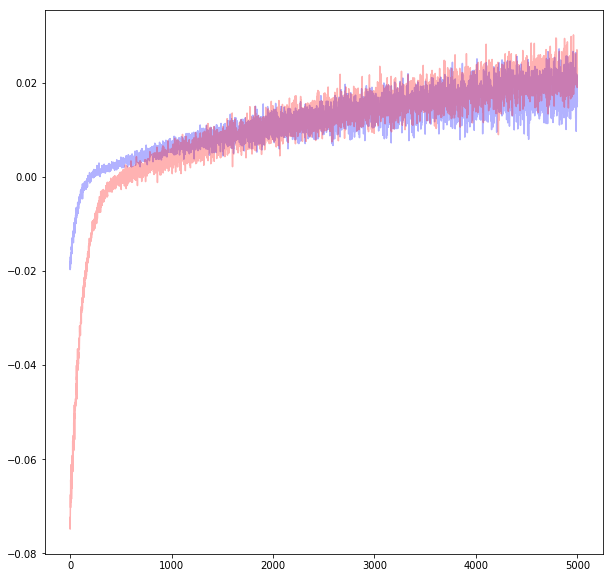

Forward MI: 0.017897138
Backward MI: 0.02212795


In [45]:
plt.figure(figsize=(10,10))
plt.plot(avg_loss, 'b', alpha=0.3)
plt.plot(avg_lossRev, 'r', alpha=0.3)
plt.show()
print('Forward MI:', np.mean(avg_loss[-500:-1]))
print('Backward MI:', np.mean(avg_lossRev[-500:-1]))